# Import statements

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd
import random

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

from plotNMM import plotNMM, slicePlotNMM
from IPython.display import display

#needed for lattice_init
#%env FACET2_LATTICE /u/ar/dcesar/notebooks/facet_bmad
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample


# Start tao

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 
#tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE'])) 

# Plot single particle twiss

In [3]:
#Helper functions for single particle Twiss plots

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches
    
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

In [4]:
elements=tao.lat_ele_list();

floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True);

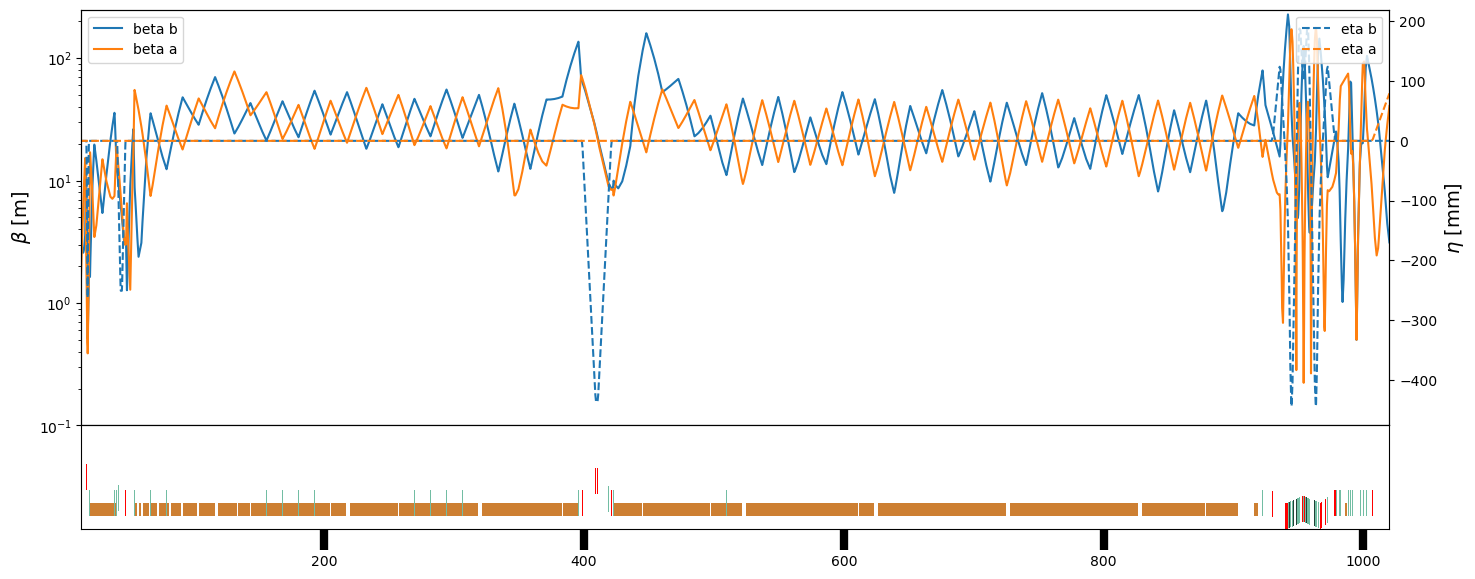

In [5]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']




#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

# Beam construction

## Import beam

In [6]:
def modifyAndSaveInputBeam(
    inputBeamFilePath,
    betaX = None,
    alphaX = None,
    betaY = None,
    alphaY = None,
    numMacroParticles = None,
    timeCenterTF = True):

    #Import
    P = ParticleGroup(inputBeamFilePath)

    #Downsample
    #if numMacroParticles:
    #    P.data.update(resample_particles(P, n=numMacroParticles))
    #PROBLEM! Built-in resampling smushes everything down to a single particle weight. No good for me since I'm using those to keep track of driver/witness
    #Instead, since the weights are ~equal, just pick a random subset then rescale their weights
    initialImportSize = np.size(P.id)
    if numMacroParticles:
        P = P[random.sample(range(initialImportSize), numMacroParticles)]
        P.weight = P.weight * (initialImportSize / numMacroParticles)
    

    #Time center
    if timeCenterTF:
        P.t=P.t-np.mean(P.t) #This is OK because present beam doesn't have different weights; np.unique(P.weight)

    #Apply linear matching
    if (betaX is not None) and (alphaX is not None):
        P.twiss_match(
              plane='x',
              beta = betaX,
              alpha = alphaX,
              inplace=True)

    if (betaY is not None) and (alphaY is not None):
        P.twiss_match(
              plane='y',
              beta = betaY,
              alpha = alphaY,
              inplace=True)

    #Write as the active file
    P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')

    #Also return the beam object
    return P

In [7]:
#numMacroParticles = 100000
#tao.cmd(f"set beam_init n_particle = {numMacroParticles}") # limit to 10k particles for now

#Change tracking start/end
#tao.cmd('set beam_init track_end = ENDDL10')
#tao.cmd('set beam_init track_end = PENT')
lastTrackedElement = "MFFF"
tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

#Can see present track_start and track_end values with `show beam`



#Optional: Enable CSR
tao.cmd(f'call {filePath}/bmad/models/f2_elec/scripts/Activate_CSR.tao')
#tao.cmd('csron')
tao.cmd('csroff')

[]

In [8]:
inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly.h5'




P = modifyAndSaveInputBeam(
    inputBeamFilePath,
    numMacroParticles = 2000
)



tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')# IF you want to change the beam to the new matched beam at the start
#tao.cmd('set beam_init position_file=/Users/cemma/Downloads/facet2-lattice/bmad/beams/L0AFEND.h5')# 
tao.cmd('reinit beam')

#P.slice_plot('norm_emit_x')
#display(slicePlotNMM(P, 'norm_emit_x') )


[]

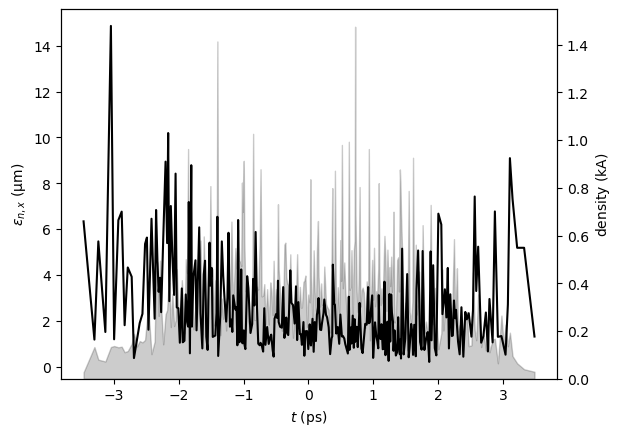

Num driver / witness macroparticles: 0 / 2000


In [9]:
#This stuff is hardcoded, beware!
#See "2024-03-29_nudgeMacroparticleWeights.ipynb"


display(slicePlotNMM(P, 'norm_emit_x', n_slice = 300, slice_key = "t"))

#By eye, pick the dividing line
witnessDriverSplitWeight = np.average(P.weight)
numMacroparticlesAsImported = np.size(P.weight)

driverSubset = P[  P.weight > witnessDriverSplitWeight ]
witnessSubset = P[ P.weight < witnessDriverSplitWeight ]

print(f"Num driver / witness macroparticles: {np.size(driverSubset.weight)} / {np.size(witnessSubset.weight)}")
P.weight;

## Track from start to MFFF

Both bunches


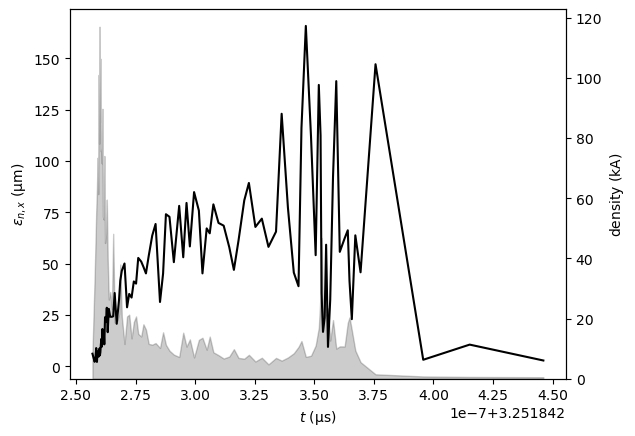

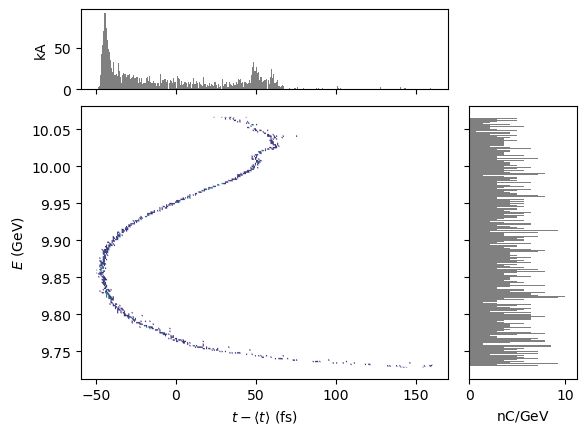

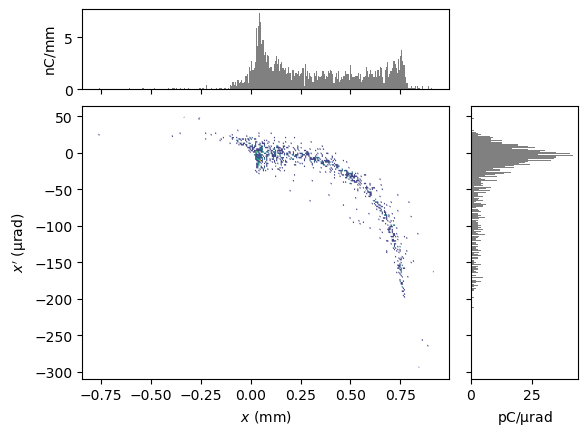

In [10]:
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


plt.close('all')
P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))

#Drop lost/nonsense particles
selectParticles = P[P.pz > 100e6]

print("Both bunches")
display(slicePlotNMM(selectParticles, 'norm_emit_x',n_slice=100))
display(plotNMM(selectParticles, 'delta_t', 'energy', bins=300))
display(plotNMM(selectParticles, "x","xp", bins=300))


## Check that we can import the MFFF beam and track

In [11]:
#Write as the active file
#P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')

#Need to explicitly add non-MARKER places to save beam...
tao.cmd("set beam add_saved_at = DTOTR")


P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')

tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')

lastTrackedElement = "end"

tao.cmd(f'set beam_init track_start = MFFF')
tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

tao.cmd('reinit beam')

[]

Both bunches


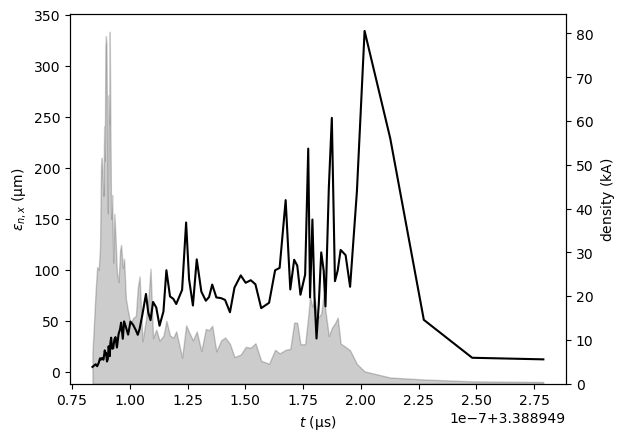

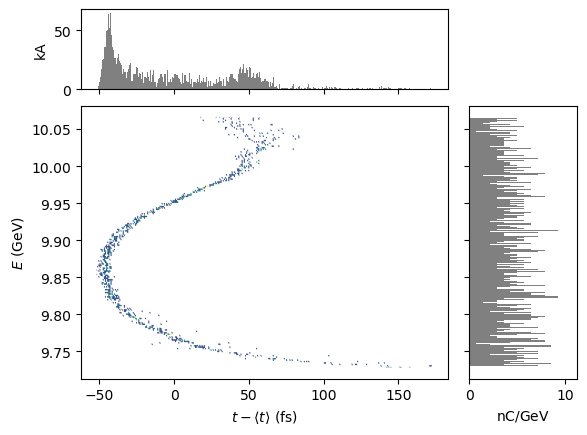

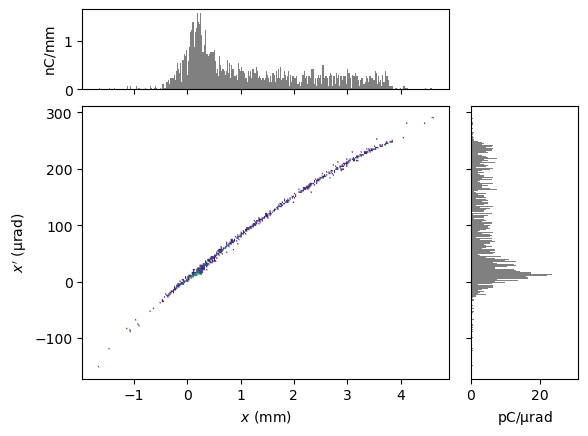

In [12]:
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


plt.close('all')
P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))

#Drop lost/nonsense particles
selectParticles = P[P.pz > 100e6]

print("Both bunches")
display(slicePlotNMM(selectParticles, 'norm_emit_x',n_slice=100))
display(plotNMM(selectParticles, 'delta_t', 'energy', bins=300))
display(plotNMM(selectParticles, "x","xp", bins=300))


# Bayesian optimization

## Utility functions

In [13]:
def setQuadkG(quadName, integratedFieldkG):
    quadLength = tao.ele_gen_attribs(quadName)["L"]

    desiredGradientkG = integratedFieldkG / quadLength

    #Bmad uses Tesla
    tao.cmd(f"set ele {quadName} B1_GRADIENT = {desiredGradientkG/10}")

    return

In [14]:
def setAllFinalFocusQuads(Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG):

    #Prevent recalculation until all magnets are set
    tao.cmd("set global lattice_calc_on = F")
    
    setQuadkG("Q5FF", Q5FFkG)
    setQuadkG("Q4FF", Q4FFkG)
    setQuadkG("Q3FF", Q3FFkG)
    setQuadkG("Q2FF", Q2FFkG)
    setQuadkG("Q1FF", Q1FFkG)
    setQuadkG("Q0FF", Q0FFkG)
    setQuadkG("Q0D", Q0DkG)
    setQuadkG("Q1D", Q1DkG)
    setQuadkG("Q2D", Q2DkG)

    tao.cmd("set global lattice_calc_on = T")

    return

quadNameList = ["Q5FF", "Q4FF", "Q3FF", "Q2FF", "Q1FF", "Q0FF", "Q0D", "Q1D", "Q2D"]

## Optimizer functions

In [15]:
def XTCAVBetaX_optimization(self, Q5FFkG, Q4FFkG, Q3FFkG):
    
    setQuadkG("Q5FF", Q5FFkG)
    setQuadkG("Q4FF", Q4FFkG)
    setQuadkG("Q3FF", Q3FFkG)

    XTCAVBetaXVal = tao.ele_twiss("XTCAVF")['beta_a']

    #Collect desired data as a pandas Series
    tmpData = pd.Series({
        "Q5FFkG": Q5FFkG,
        "Q4FFkG": Q4FFkG,
        "Q3FFkG": Q3FFkG,
        "XTCAVBetaX": XTCAVBetaXVal
    #   "finalEmit": finalEmit,
    #   "initialBeam": ParticleGroup(data=tao.bunch_data('L0AFEND')),
    #   "finalBeam": ParticleGroup(data=tao.bunch_data(lastTrackedElement))
    #    "fig": outputFig
    })


    #Split this out to below the export commands so beams can be exported
    #tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
    
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    self.updatePlot()


    
    return XTCAVBetaXVal

In [16]:
def finalFocus_optimization(self, Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG):
    

    badValue = -1 #The value returned for illegal config
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setAllFinalFocusQuads(Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG)
        tao.cmd("set ele XTCAVF VOLTAGE = 10e6")
        tao.cmd("set ele XTCAVF PHI0 = 0")
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue
    
    
    DTOTRSigmaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_sigma_x']
    DTOTRBetaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_beta_x']

    try:
        tao.cmd("set ele XTCAVF VOLTAGE = 0e6")
        tao.cmd("set ele XTCAVF PHI0 = 0")
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue
    
    DTOTRSigmaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_sigma_x']
    DTOTRBetaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_beta_x']



    maximizeMe = DTOTRSigmaXValTCAVOn / DTOTRSigmaXValTCAVOff
 
    
    
    
    
    bigCost = -1000
    betaThresh = 1e4
    
    #This is just a toy version for now; impose cost for beams that are too big
    for quadName in quadNameList: 
        #if tao.ele_twiss(quadName)['beta_a'] > 1e4: maximizeMe += bigCost
        #if tao.ele_twiss(quadName)['beta_b'] > 1e4: maximizeMe += bigCost
        
        #Instead of a fixed amount, let there be some gradient
        if tao.ele_twiss(quadName)['beta_a'] > betaThresh: maximizeMe += -1*1e-2*(tao.ele_twiss(quadName)['beta_a']-betaThresh)
        if tao.ele_twiss(quadName)['beta_b'] > betaThresh: maximizeMe += -1*1e-2*(tao.ele_twiss(quadName)['beta_b']-betaThresh)

    
    #Collect desired data as a pandas Series
    tmpData = pd.Series({
        "Q5FFkG": Q5FFkG,
        "Q4FFkG": Q4FFkG,
        "Q3FFkG": Q3FFkG,
        "Q2FFkG": Q2FFkG,
        "Q1FFkG": Q1FFkG,
        "Q0FFkG": Q0FFkG,
        "Q0DkG": Q0DkG,
        "Q1DkG": Q1DkG,
        "Q2DkG": Q2DkG,
        "XTCAVBetaX": tao.bunch_params("DTOTR")['twiss_beta_x'],
        "DTOTRSigmaXValTCAVOn": DTOTRSigmaXValTCAVOn,
        "DTOTRSigmaXValTCAVOff": DTOTRSigmaXValTCAVOff,
        "DTOTRBetaXValTCAVOn": DTOTRBetaXValTCAVOn,
        "DTOTRBetaXValTCAVOff": DTOTRBetaXValTCAVOff,
        "maximizeMe": maximizeMe
    #   "finalEmit": finalEmit,
    #   "initialBeam": ParticleGroup(data=tao.bunch_data('L0AFEND')),
    #   "finalBeam": ParticleGroup(data=tao.bunch_data(lastTrackedElement))
    #    "fig": outputFig
    })


    #Split this out to below the export commands so beams can be exported
    tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
    
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    self.updatePlot()

    
    
    return maximizeMe

In [17]:
def finalFocusAndLaunch_optimization(self, 
                                     launchBetaX, launchAlphaX, launchBetaY, launchAlphaY, 
                                     Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG):
   
    ######################################################################################
    #First import "clean" beam and do modification at launch point
    ######################################################################################

    inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly.h5'

    tao.cmd('reinit beam')

    P = modifyAndSaveInputBeam(
        inputBeamFilePath,
        numMacroParticles = 5000,
        betaX = launchBetaX,
        alphaX = launchAlphaX,
        betaY = launchBetaY,
        alphaY = launchAlphaY
    )

    P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')
    inputBeamFilePath = f'{filePath}/bmad/beams/activeBeamFile.h5'

    ##################################
    #Propagate to MFFF and save result
    ##################################
    tao.cmd(f'set beam_init track_start = L0AFEND')
    lastTrackedElement = "MFFF"
    tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

    tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
    tao.cmd('reinit beam')

    tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
    tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))

    P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')

    #####################################################
    #Import the MFFF beam and prepare to simulate to end
    #####################################################
    tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
    tao.cmd(f'set beam_init track_start = MFFF')
    tao.cmd(f'set beam_init track_end = end')
    tao.cmd('reinit beam')

    
    ################################################################################
    #Do finalFocus_optimization; copy-paste from above, adding new saved parameters
    ################################################################################
    
    badValue = -1 #The value returned for illegal config
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setAllFinalFocusQuads(Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG)
        tao.cmd("set ele XTCAVF VOLTAGE = 10e6")
        tao.cmd("set ele XTCAVF PHI0 = 0")
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue
    
    
    DTOTRSigmaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_sigma_x']
    DTOTRBetaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_beta_x']

    try:
        tao.cmd("set ele XTCAVF VOLTAGE = 0e6")
        tao.cmd("set ele XTCAVF PHI0 = 0")
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue
    
    DTOTRSigmaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_sigma_x']
    DTOTRBetaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_beta_x']



    maximizeMe = DTOTRSigmaXValTCAVOn / DTOTRSigmaXValTCAVOff
 
    
    
    
    
    bigCost = -1000
    betaThresh = 1e4
    
    #This is just a toy version for now; impose cost for beams that are too big
    for quadName in quadNameList: 
        #if tao.ele_twiss(quadName)['beta_a'] > 1e4: maximizeMe += bigCost
        #if tao.ele_twiss(quadName)['beta_b'] > 1e4: maximizeMe += bigCost
        
        #Instead of a fixed amount, let there be some gradient
        if tao.ele_twiss(quadName)['beta_a'] > betaThresh: maximizeMe += -1*1e-2*(tao.ele_twiss(quadName)['beta_a']-betaThresh)
        if tao.ele_twiss(quadName)['beta_b'] > betaThresh: maximizeMe += -1*1e-2*(tao.ele_twiss(quadName)['beta_b']-betaThresh)

    
    #Collect desired data as a pandas Series
    tmpData = pd.Series({
        "launchBetaX": launchBetaX,
        "launchAlphaX": launchAlphaX,
        "launchBetaY": launchBetaY,
        "launchAlphaY": launchAlphaY,
        "Q5FFkG": Q5FFkG,
        "Q4FFkG": Q4FFkG,
        "Q3FFkG": Q3FFkG,
        "Q2FFkG": Q2FFkG,
        "Q1FFkG": Q1FFkG,
        "Q0FFkG": Q0FFkG,
        "Q0DkG": Q0DkG,
        "Q1DkG": Q1DkG,
        "Q2DkG": Q2DkG,
        "XTCAVBetaX": tao.bunch_params("DTOTR")['twiss_beta_x'],
        "DTOTRSigmaXValTCAVOn": DTOTRSigmaXValTCAVOn,
        "DTOTRSigmaXValTCAVOff": DTOTRSigmaXValTCAVOff,
        "DTOTRBetaXValTCAVOn": DTOTRBetaXValTCAVOn,
        "DTOTRBetaXValTCAVOff": DTOTRBetaXValTCAVOff,
        "maximizeMe": maximizeMe
    })


    #Split this out to below the export commands so beams can be exported
    tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
    
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    self.updatePlot()

    
    
    return maximizeMe

## Do optimization

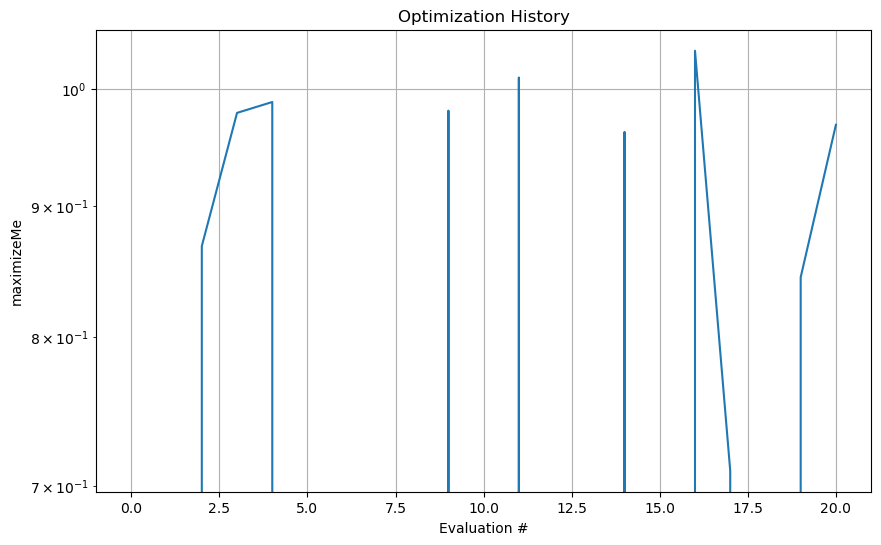

| 21        | 0.968     | -113.0    | 122.9     | 290.3     | -185.7    | -85.39    | 95.66     | 346.8     | -357.1    | -177.6    | 2.835     | 3.784     | 22.64     | 19.52     |
   launchBetaX  launchAlphaX  launchBetaY  launchAlphaY      Q5FFkG  \
0    57.965365      0.465801    24.311657     -0.969666 -154.427527   
0    13.647303      1.637664    12.280610     -2.578887 -137.877708   
0    21.410571     -0.834433    36.996631     -4.271523 -152.077898   
0    62.407706      2.154280    44.708080      5.422377 -210.710027   
0    74.681489      5.082025    71.607892     -1.955717 -119.175926   
0    29.674926      1.400108    55.849702     -4.821658 -146.254039   
0    28.726481      5.132618    51.893455     -5.377960 -233.480174   
0    63.794636      0.547914    62.643859      5.848025 -210.329974   
0    36.317583      1.622661    53.170436     -4.757822 -210.407668   
0    25.581493     -1.508843    31.806444      4.998508  -62.153932   
0    12.150163     -1.516945    24.34

In [18]:
##### from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from IPython.display import display, clear_output

#Try https://github.com/bayesian-optimization/BayesianOptimization
#from bayes_opt import BayesianOptimization
import bayes_opt

class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()

    def updatePlot(self):
        plotKey = "maximizeMe"
        
        # Clear the previous figure to prevent flickering
        clear_output(wait=True)
        
        # Create a new figure
        plt.figure(figsize=(10, 6))
        #plt.plot(self.history.index, self.history['finalEmit'], '-o', markersize=8)
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        # Show plot
        plt.show()


# Attach the function to the class as a method
OptimizationProblem.finalFocus_optimization = finalFocusAndLaunch_optimization

# Instantiate the optimization problem
problem = OptimizationProblem()




# Bounded region of parameter space
pbounds = {
    'launchBetaX': (10, 80),
    'launchAlphaX': (-6, 6),
    'launchBetaY': (10, 80),
    'launchAlphaY': (-6, 6),
    
    #Full SCP ranges
    'Q5FFkG': (-256, 0), 
    'Q4FFkG': (-446, 0), 
    'Q3FFkG': (0, 457),
    'Q2FFkG': (0, 167),
    'Q1FFkG': (-257, 0),
    'Q0FFkG': (0, 167),
    'Q0DkG': (-239, 0),
    'Q1DkG': (0, 386),
    'Q2DkG': (-223, 0),

    #Conservative testing range
    #'Q5FFkG': (-200, 0), 
    #'Q4FFkG': (-200, 0), 
    #'Q3FFkG': (0, 200),
    #'Q2FFkG': (0, 200),
    #'Q1FFkG': (-100, 0),
    #'Q0FFkG': (0, 100),
    #'Q0DkG': (-100, 0),
    #'Q1DkG': (0, 200),
    #'Q2DkG': (-100, 0),
}

optimizer = bayes_opt.BayesianOptimization(
    f=problem.finalFocus_optimization,
    pbounds=pbounds,
    random_state=1,
    allow_duplicate_points=True #2024-04-26 it was whining about this 
)

#Refer to https://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
#and https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
boInitialKappa = 10.
boFinalKappa = 0.1
boNumIter = 20
boKappaDecay = (boFinalKappa / boInitialKappa)**(1/boNumIter)

acquisition_function = bayes_opt.util.UtilityFunction(kind='ucb',
                                   kappa=boInitialKappa,         #Default 2.576
                                   xi=0.0,              #Default 0
                                   kappa_decay=boKappaDecay,       #Default 0
                                   kappa_decay_delay=0  #Default 0                     
                                          )


optimizer.maximize(
    init_points=0, #Initial, random points
    n_iter=boNumIter,
    acquisition_function=acquisition_function
)


#print(res)
print(problem.history) 

## Check out results

In [19]:
problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)
bestConfigData = problem.history.iloc[0]

print( bestConfigData ) 

setAllFinalFocusQuads(
    bestConfigData["Q5FFkG"], 
    bestConfigData["Q4FFkG"], 
    bestConfigData["Q3FFkG"], 
    bestConfigData["Q2FFkG"], 
    bestConfigData["Q1FFkG"], 
    bestConfigData["Q0FFkG"], 
    bestConfigData["Q0DkG"], 
    bestConfigData["Q1DkG"], 
    bestConfigData["Q2DkG"]
)

tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

launchBetaX               68.592703
launchAlphaX              -0.115068
launchBetaY               20.584826
launchAlphaY               2.625101
Q5FFkG                   -43.165356
Q4FFkG                   -27.005574
Q3FFkG                    41.290136
Q2FFkG                    74.459641
Q1FFkG                  -170.256191
Q0FFkG                   165.902899
Q0DkG                   -130.628349
Q1DkG                     13.680937
Q2DkG                   -103.156976
XTCAVBetaX               583.745940
DTOTRSigmaXValTCAVOn       0.001597
DTOTRSigmaXValTCAVOff      0.001543
DTOTRBetaXValTCAVOn      622.260243
DTOTRBetaXValTCAVOff     583.745940
maximizeMe                 1.034650
Name: 0, dtype: float64


[]

In [20]:
problem.history.to_csv('output_data.csv', index=False)

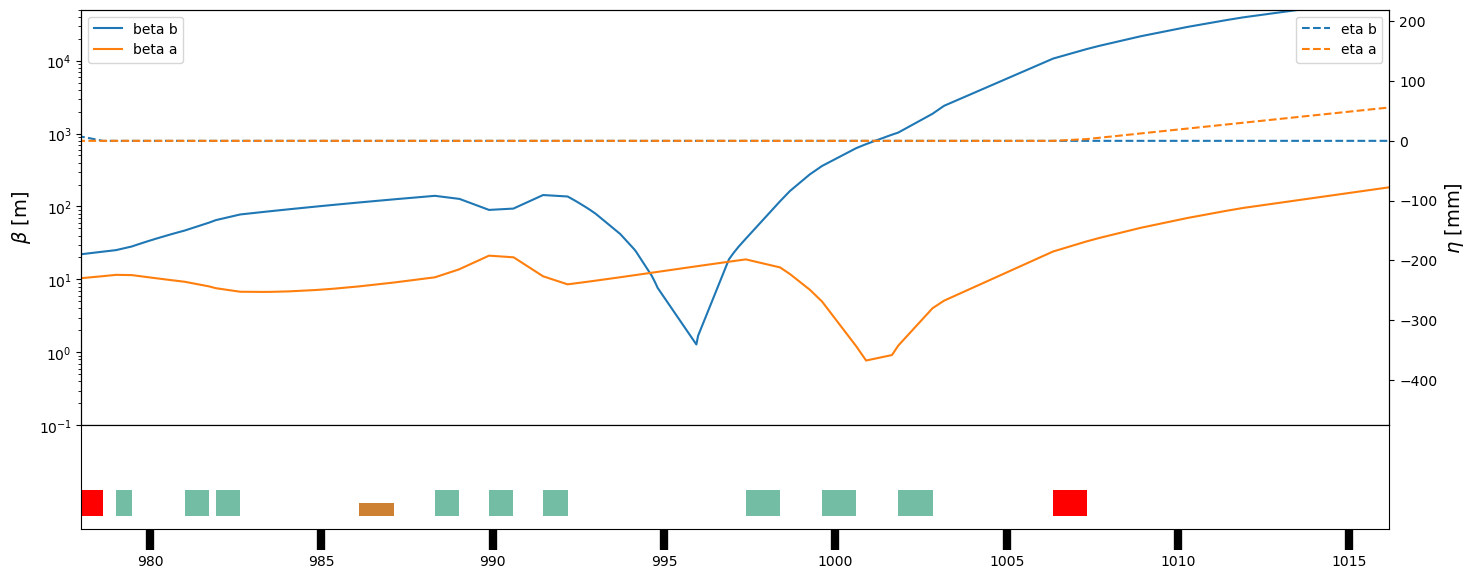

In [21]:
elements=tao.lat_ele_list();


floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)


#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,50000])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=978
zmax=1016.162829 #DTOTR S = 1016.162829

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)



In [22]:
tao.cmd("set ele XTCAVF VOLTAGE = 10e6")
tao.cmd("set ele XTCAVF PHI0 = 0")
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


PTCAVOn = ParticleGroup(data=tao.bunch_data("DTOTR"))


tao.cmd("set ele XTCAVF VOLTAGE = 0")
tao.cmd("set ele XTCAVF PHI0 = 0")
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


PTCAVOff = ParticleGroup(data=tao.bunch_data("DTOTR"))

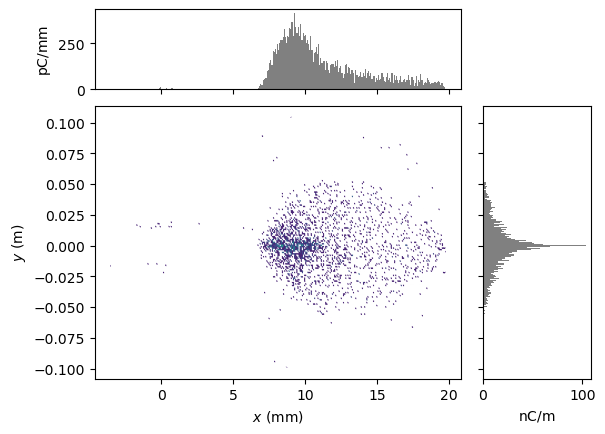

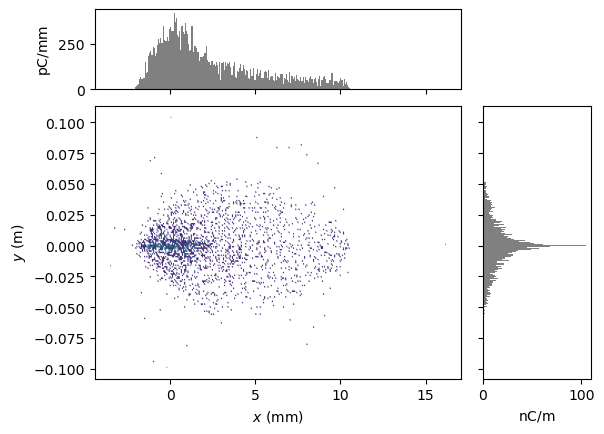

In [23]:
display(plotNMM(PTCAVOn, 'x', 'y', bins=300))
display(plotNMM(PTCAVOff, 'x', 'y', bins=300))